Classes: ['herniated', 'normal']
Epoch 1/30 | Train Loss: 0.5144, Acc: 0.7365 | Val Loss: 0.6137, Acc: 0.6784, AUC: 0.7353
Epoch 2/30 | Train Loss: 0.1059, Acc: 0.9695 | Val Loss: 0.2958, Acc: 0.8667, AUC: 0.9317
Epoch 3/30 | Train Loss: 0.0287, Acc: 0.9971 | Val Loss: 0.2514, Acc: 0.8941, AUC: 0.9526
Epoch 4/30 | Train Loss: 0.0090, Acc: 1.0000 | Val Loss: 0.2640, Acc: 0.9098, AUC: 0.9566
Epoch 5/30 | Train Loss: 0.0071, Acc: 0.9990 | Val Loss: 0.1911, Acc: 0.9216, AUC: 0.9711
Epoch 6/30 | Train Loss: 0.0035, Acc: 1.0000 | Val Loss: 0.1864, Acc: 0.9333, AUC: 0.9786
Epoch 7/30 | Train Loss: 0.0040, Acc: 1.0000 | Val Loss: 0.2554, Acc: 0.9059, AUC: 0.9832
Epoch 8/30 | Train Loss: 0.0161, Acc: 0.9931 | Val Loss: 0.4535, Acc: 0.8824, AUC: 0.9184
Epoch 9/30 | Train Loss: 0.0675, Acc: 0.9725 | Val Loss: 0.9660, Acc: 0.7451, AUC: 0.8934
Epoch 10/30 | Train Loss: 0.0836, Acc: 0.9754 | Val Loss: 0.4279, Acc: 0.8431, AUC: 0.9288
Epoch 11/30 | Train Loss: 0.0474, Acc: 0.9853 | Val Loss: 0.2928, 

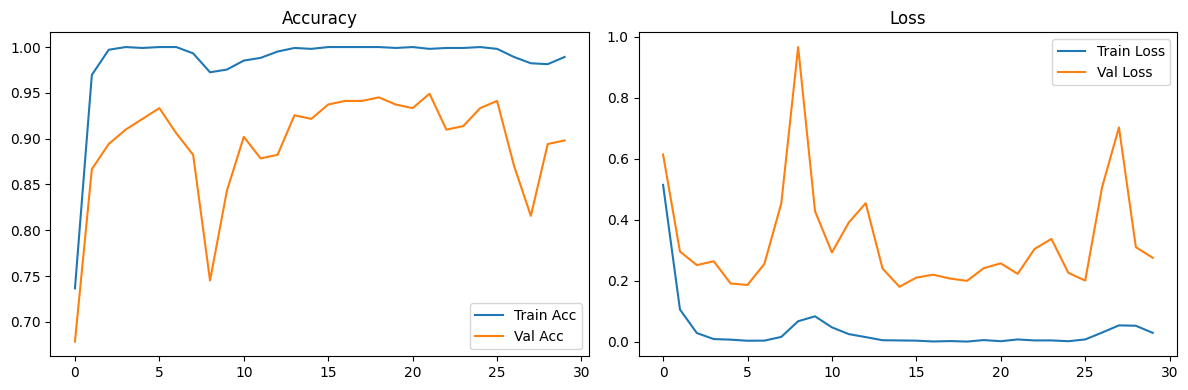

✅ Saved model to app/ldh_classifier.pt

Confusion Matrix:
 [[207  22]
 [  3  85]]


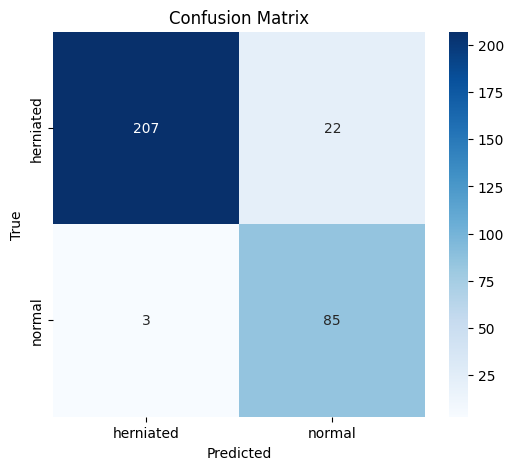


Classification Report:
               precision    recall  f1-score   support

   herniated      0.986     0.904     0.943       229
      normal      0.794     0.966     0.872        88

    accuracy                          0.921       317
   macro avg      0.890     0.935     0.907       317
weighted avg      0.933     0.921     0.923       317

AUC-ROC Score: 0.9837


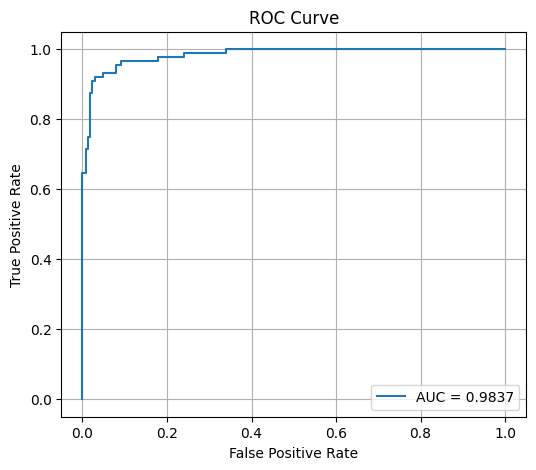

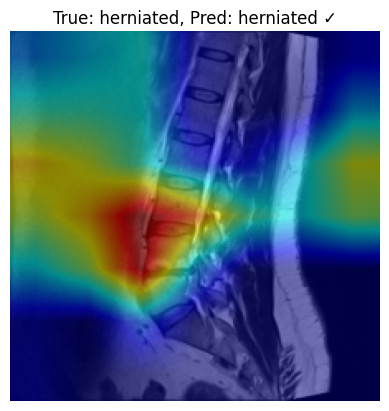

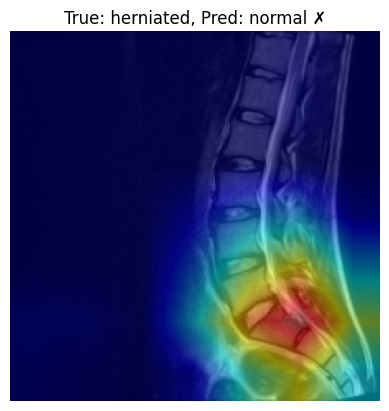

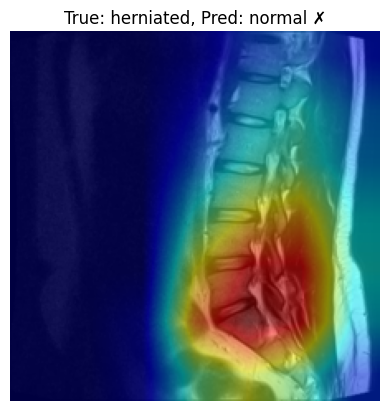

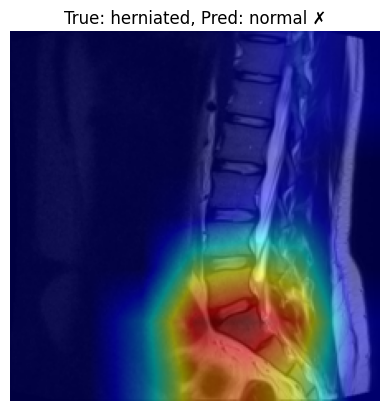

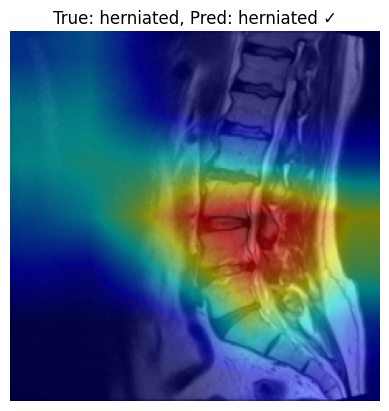

In [1]:
# === STEP 1: Imports ===
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet18, ResNet18_Weights

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# === CONFIG: Parameters and Directories ===
img_size = 224
batch_size = 32
num_epochs = 30
train_val_dir = 'images_unbal_model/train_val'
test_dir = 'images_unbal_model/test'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Save model + metadata in app/
OUT_DIR = Path("app")
OUT_DIR.mkdir(exist_ok=True)
MODEL_PATH = OUT_DIR / "ldh_classifier.pt"
LABELS_PATH = OUT_DIR / "labels.json"

# === TRANSFORMS ===
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# === DATASETS ===
train_val_dataset = datasets.ImageFolder(root=train_val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
class_names = train_val_dataset.classes
LABELS_PATH.write_text(json.dumps(class_names))
print("Classes:", class_names)

train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# === MODEL ===
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 2)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# === TRAINING ===
train_acc_list, val_acc_list = [], []
train_loss_list, val_loss_list = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

    train_loss = total_loss / len(train_loader.dataset)
    train_acc = correct / len(train_loader.dataset)

    model.eval()
    val_loss, val_correct = 0.0, 0
    all_probs, all_targets = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            all_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    val_auc = roc_auc_score(all_targets, all_probs)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, AUC: {val_auc:.4f}")

# === PLOT ACCURACY AND LOSS ===
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.tight_layout()
plt.show()

# === SAVE MODEL (with metadata) ===
torch.save({
    "state_dict": model.state_dict(),
    "class_names": class_names,
    "img_size": img_size,
    "grayscale": True,
    "normalize": {"mean":[0.5], "std":[0.5]},
    "arch": "resnet18-1ch"
}, MODEL_PATH)

print(f"✅ Saved model to {MODEL_PATH}")

# === EVALUATION ===
def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            preds = torch.argmax(outputs, 1).cpu().numpy()
            labels = labels.numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)
            all_probs.extend(probs.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=3)
    auc = roc_auc_score(all_labels, all_probs)

    print("\nConfusion Matrix:\n", cm)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print("\nClassification Report:\n", report)
    print(f"AUC-ROC Score: {auc:.4f}")

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

evaluate_model(model, test_loader, class_names)

# === GRAD-CAM VISUALIZATION ===
def visualize_gradcam_batch(model, dataset, class_names, num_samples=5):
    model.eval()
    target_layer = model.layer4[-1]
    cam = GradCAM(model=model, target_layers=[target_layer])

    for i in range(num_samples):
        input_tensor, true_label = dataset[i]
        input_batch = input_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(input_batch)
            pred_label = torch.argmax(outputs, dim=1).item()

        grayscale_cam = cam(input_tensor=input_batch,
                            targets=[ClassifierOutputTarget(pred_label)],
                            aug_smooth=False,
                            eigen_smooth=False)[0]

        img_np = input_tensor.squeeze().cpu().numpy()
        img_rgb = np.stack([img_np]*3, axis=-1)
        img_rgb = (img_rgb - img_rgb.min()) / (img_rgb.max() - img_rgb.min() + 1e-5)

        cam_image = show_cam_on_image(img_rgb, grayscale_cam, use_rgb=True)

        correct = "✓" if pred_label == true_label else "✗"
        plt.imshow(cam_image)
        plt.title(f"True: {class_names[true_label]}, Pred: {class_names[pred_label]} {correct}")
        plt.axis('off')
        plt.show()

# === RUN GRAD-CAM VISUALIZATIONS ===
visualize_gradcam_batch(model, test_dataset, class_names, num_samples=5)


In [ ]:
from pathlib import Path
Path("app").mkdir(exist_ok=True)

# --- app/predict.py ---
predict_code = """
import io, json
from pathlib import Path
from typing import List, Tuple
import torch, torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = Path(__file__).with_name("ldh_classifier.pt")
LABELS_PATH = Path(__file__).with_name("labels.json")

_model = None
_labels = None
_tfms = None

def _load():
    global _model, _labels, _tfms
    if _model is None:
        ckpt = torch.load(MODEL_PATH, map_location="cpu")
        _labels = ckpt.get("class_names", json.loads(LABELS_PATH.read_text()))
        m = models.resnet18(weights=None)
        m.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        m.fc = nn.Linear(m.fc.in_features, len(_labels))
        m.load_state_dict(ckpt["state_dict"], strict=True)
        m.eval()
        _model = m.to(DEVICE)

        img_size = ckpt.get("img_size", 224)
        mean = ckpt.get("normalize", {}).get("mean", [0.5])
        std = ckpt.get("normalize", {}).get("std", [0.5])
        _tfms = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])
    return _model, _labels, _tfms

def predict_image(img_bytes: bytes, topk: int = 2) -> List[Tuple[str, float]]:
    model, labels, tfms = _load()
    img = Image.open(io.BytesIO(img_bytes)).convert("RGB")
    x = tfms(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        probs = F.softmax(model(x), dim=1)[0].cpu()
    vals, idxs = torch.topk(probs, k=min(topk, len(labels)))
    return [(labels[i], float(vals[j])) for j, i in enumerate(idxs.tolist())]
"""
Path("app/predict.py").write_text(predict_code)

# --- app/app.py ---
app_code = """
import streamlit as st
from predict import predict_image

st.set_page_config(page_title=" LDH Classifier", layout="centered")

st.markdown('<div class="app-card">', unsafe_allow_html=True)
st.title(" Lumbar Disc Herniation Classifier")
st.caption("Upload an MRI slice to predict whether the case shows herniation or not. (Educational demo only)")

uploaded = st.file_uploader("Upload a spine image", type=["png","jpg","jpeg"])
if uploaded:
    st.image(uploaded, use_column_width=True)
    if st.button("✨ Predict", use_container_width=True):
        preds = predict_image(uploaded.read(), topk=2)
        top1 = preds[0]
        st.markdown(f"<span style='color:green;font-weight:600;'>Prediction: {top1[0]} ({top1[1]:.1%})</span>", unsafe_allow_html=True)
        st.table({"label": [l for l,_ in preds], "probability": [f"{p:.2%}" for _,p in preds]})

st.markdown("<div style='color:gray;font-size:0.85rem;margin-top:1rem;'>Built with Streamlit • Not for clinical use</div>", unsafe_allow_html=True)
"""
Path("app/app.py").write_text(app_code)

print("✅ Streamlit app created. Run with: streamlit run app/app.py")


✅ Streamlit app created. Run with: streamlit run app/app.py


In [ ]:
from pathlib import Path

Path(".").mkdir(exist_ok=True)

# --- requirements.txt ---
Path("requirements.txt").write_text("""\
streamlit==.37.1
torch==2.4.1
torchvision==0.19.1
Pillow==10.4.0
pytest==8.3.2
""")

# --- Dockerfile ---
Path("Dockerfile").write_text("""\
FROM python:3.11-slim

ENV PYTHONDONTWRITEBYTECODE=1 PYTHONUNBUFFERED=1 PIP_NO_CACHE_DIR=1 STREAMLIT_SERVER_ADDRESS=0.0.0.0 STREAMLIT_SERVER_PORT=8501
WORKDIR /app

RUN apt-get update && apt-get install -y --no-install-recommends wget && rm -rf /var/lib/apt/lists/*

COPY requirements.txt .
RUN pip install -r requirements.txt

COPY app ./app

EXPOSE 8501
HEALTHCHECK CMD wget -qO- http://localhost:8501/_stcore/health || exit 1
CMD ["streamlit", "run", "app/app.py"]
""")

# --- .dockerignore ---
Path(".dockerignore").write_text("""\
__pycache__/
*.ipynb_checkpoints
.git
images_unbal_model/
data/
""")

print("✅ Docker setup ready. Build with: docker build -t ldh-streamlit .")


✅ Docker setup ready. Build with: docker build -t ldh-streamlit .


In [4]:
from pathlib import Path

Path("tests").mkdir(exist_ok=True)
Path("tests/test_ldh_smoke.py").write_text("""\
from app.predict import predict_image
from PIL import Image
import io

def test_predict_on_dummy_image():
    img = Image.new("RGB", (224,224), color=(128,128,128))
    buf = io.BytesIO()
    img.save(buf, format="PNG")
    preds = predict_image(buf.getvalue(), topk=2)
    assert len(preds) >= 1
""")


297

In [5]:
from pathlib import Path

wf_dir = Path(".github/workflows")
wf_dir.mkdir(parents=True, exist_ok=True)

ci_yaml = """\
name: CI

on:
  push:
    branches: [ main ]
    tags: [ 'v*.*.*' ]
  pull_request:

jobs:
  test-and-build:
    runs-on: ubuntu-latest
    permissions:
      contents: read
      packages: write
      id-token: write

    steps:
      - name: Checkout
        uses: actions/checkout@v4

      - name: Add repo to PYTHONPATH
        run: echo "PYTHONPATH=$GITHUB_WORKSPACE" >> $GITHUB_ENV

      - name: Set up Python
        uses: actions/setup-python@v5
        with:
          python-version: '3.11'

      - name: Install deps
        run: |
          python -m pip install -U pip
          pip install -r requirements.txt

      - name: Run tests
        run: pytest -q

      # 👇 Hardcode owner/image here to avoid the empty owner problem
      - name: Docker metadata
        id: meta
        uses: docker/metadata-action@v5
        with:
          images: ghcr.io/dineifb/ldh-streamlit
          tags: |
            type=raw,value=latest,enable={{is_default_branch}}
            type=ref,event=tag
            type=sha

      - name: Set up QEMU
        uses: docker/setup-qemu-action@v3

      - name: Set up Buildx
        uses: docker/setup-buildx-action@v3

      - name: Login to GHCR
        uses: docker/login-action@v3
        with:
          registry: ghcr.io
          username: ${{ github.actor }}
          password: ${{ secrets.GITHUB_TOKEN }}

      - name: Build and (conditionally) push (multi-arch)
        uses: docker/build-push-action@v6
        with:
          context: .
          file: ./Dockerfile
          platforms: linux/amd64,linux/arm64
          push: ${{ github.event_name != 'pull_request' && (github.ref == 'refs/heads/main' || startsWith(github.ref, 'refs/tags/')) }}
          tags: ${{ steps.meta.outputs.tags }}
          labels: ${{ steps.meta.outputs.labels }}
          cache-from: type=gha
          cache-to: type=gha,mode=max
"""
(wf_dir / "ci.yml").write_text(ci_yaml)

print("✅ Created: .github/workflows/ci.yml")


✅ Created: .github/workflows/ci.yml
